
Datset from; https://sysomics.com/Download/ "Secreted protein database(SPD)"


In [ ]:
import pandas as pd
import random
from tqdm import tqdm
from joblib import Parallel, delayed
from Bio import ExPASy
from Bio import SwissProt
import requests
from requests.exceptions import RequestException
import time

def fetch_sequence(uniprot_id, verbose=False):
    """Fetch protein sequence from UniProt in FASTA format."""
    try:
        if verbose:
            print(f"Fetching sequence for {uniprot_id}...")
        url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        sequence = ''.join(response.text.splitlines()[1:])
        return sequence
    except RequestException as e:
        if verbose:
            print(f"Request failed for {uniprot_id}: {e}")
        return None

def get_human_proteins_from_csv(csv_path, max_proteins=None):
    """Load human proteins from CSV, optionally limiting to max_proteins."""
    print(f"Loading human proteins from {csv_path}...")
    df = pd.read_csv(csv_path)
    
    # Extract only the first protein ID from each entry
    human_proteins = df[(df['Species'] == 'HUMAN') & (df["Ranking"] == "rank3")]['AccessionNumberorgiNumber'].tolist()
    human_proteins = [str(pid).split()[0] for pid in human_proteins]  # Take first ID only
    
    if max_proteins is not None and max_proteins < len(human_proteins):
        print(f"Randomly sampling {max_proteins} from {len(human_proteins)} human proteins...")
        human_proteins = random.sample(human_proteins, max_proteins)
        print(f"Selected {len(human_proteins)} human proteins from CSV.")
    else:
        print(f"Found {len(human_proteins)} human proteins in CSV.")
    
    return human_proteins

def get_all_reviewed_proteins(max_fetch=50000):
    """Fetch a large pool of reviewed protein IDs to sample from."""
    print(f"Building pool of reviewed proteins (fetching up to {max_fetch})...")
    all_proteins = []
    batch_size = 500
    
    for offset in tqdm(range(0, max_fetch, batch_size), desc="Fetching protein pool"):
        try:
            url = f"https://rest.uniprot.org/uniprotkb/search?query=reviewed:true&format=json&size={batch_size}&offset={offset}&fields=accession"
            response = requests.get(url, timeout=15)
            response.raise_for_status()
            data = response.json()
            results = data.get("results", [])
            
            if not results:
                break
                
            for protein in results:
                all_proteins.append(protein["primaryAccession"])
                
        except Exception as e:
            print(f"Error at offset {offset}: {e}")
            break
    
    print(f"Collected {len(all_proteins)} reviewed proteins in pool.")
    return all_proteins

def select_random_human_proteins(num_proteins, use_large_pool=True):
    """
    Select random proteins from UniProt.
    
    Args:
        num_proteins: Number of random proteins to select
        use_large_pool: If True, fetch a large pool first then sample randomly (recommended)
                       If False, use the faster but less random offset method
    """
    print(f"Selecting {num_proteins} random proteins from UniProt...")
    
    if use_large_pool:
        # Method 1: Fetch large pool, then random sample (truly random)
        pool_size = min(50000, num_proteins * 500)  # Fetch 50x more than needed
        protein_pool = get_all_reviewed_proteins(max_fetch=pool_size)
        
        if len(protein_pool) < num_proteins:
            print(f"Warning: Only found {len(protein_pool)} proteins, using all of them")
            return protein_pool
        
        selected = random.sample(protein_pool, num_proteins)
        print(f"Randomly sampled {len(selected)} proteins from pool of {len(protein_pool)}")
        return selected
    else:
        # Method 2: Use random offsets (faster but less random)
        print("Using fast offset-based selection (less random)...")
        all_proteins = []
        seen = set()
        
        # Generate random offsets
        max_offset = 500000  # Approximate size of SwissProt
        random_offsets = random.sample(range(0, max_offset, 500), (num_proteins // 500) + 3)
        
        def fetch_batch_at_offset(offset):
            try:
                url = f"https://rest.uniprot.org/uniprotkb/search?query=reviewed:true&format=json&size=500&offset={offset}&fields=accession"
                response = requests.get(url, timeout=15)
                response.raise_for_status()
                data = response.json()
                results = data.get("results", [])
                return [protein["primaryAccession"] for protein in results]
            except:
                return []
        
        # Fetch batches in parallel
        batch_results = Parallel(n_jobs=4)(
            delayed(fetch_batch_at_offset)(offset) 
            for offset in tqdm(random_offsets, desc="Fetching random batches")
        )
        
        # Deduplicate
        for batch in batch_results:
            for pid in batch:
                if pid not in seen:
                    seen.add(pid)
                    all_proteins.append(pid)
        
        # Shuffle and select
        random.shuffle(all_proteins)
        selected = all_proteins[:num_proteins]
        print(f"Selected {len(selected)} proteins using random offsets")
        return selected

def create_protein_dataframe(csf_proteins, random_proteins, n_jobs=-1):
    """Create a DataFrame with protein sequences and labels."""
    print(f"Fetching sequences for {len(csf_proteins) + len(random_proteins)} proteins using {n_jobs if n_jobs > 0 else 'all'} cores...")
    all_proteins = csf_proteins + random_proteins
    
    # Parallel fetch with progress bar
    sequences = Parallel(n_jobs=n_jobs, backend='threading')(
        delayed(fetch_sequence)(pid, verbose=False) 
        for pid in tqdm(all_proteins, desc="Fetching sequences")
    )
    
    # Filter out failed requests
    valid_entries = [(pid, seq) for pid, seq in zip(all_proteins, sequences) if seq]
    failed = len(all_proteins) - len(valid_entries)
    if failed > 0:
        print(f"Warning: {failed} sequences failed to fetch")
    
    all_proteins, sequences = zip(*valid_entries) if valid_entries else ([], [])
    
    df = pd.DataFrame({
        'protein': all_proteins,
        'sequence': sequences,
        'label': [1 if pid in csf_proteins else 0 for pid in all_proteins]
    })
    print(f"Protein DataFrame created with {len(df)} proteins.")
    return df

def assign_set(label):
    """Assign train/test/validation set."""
    r = random.random()
    if r < 0.7:
        return 'train'
    elif r < 0.85:
        return 'validation'
    else:
        return 'test'

def main(csv_path, max_secreted_proteins=None, n_jobs_fetch=-1, truly_random=True):
    """
    Main function to process proteins.
    
    Args:
        csv_path: Path to the CSV file with secreted proteins
        max_secreted_proteins: Maximum number of secreted proteins to use (None = use all)
        n_jobs_fetch: Number of parallel jobs for sequence fetching (-1 = all cores)
        truly_random: If True, fetch large pool then sample (slower but truly random)
                     If False, use random offsets (faster but less random)
    """
    csf_proteins = get_human_proteins_from_csv(csv_path, max_proteins=max_secreted_proteins)
    num_csf = len(csf_proteins)
    print(f"Using {num_csf} secreted proteins")
    random_proteins = select_random_human_proteins(num_csf, use_large_pool=truly_random)
    df = create_protein_dataframe(csf_proteins, random_proteins, n_jobs=n_jobs_fetch)
    df['set'] = df['label'].apply(assign_set)
    print("Finished processing proteins.")
    return df

# Usage
csv_path = "/home/gdallagl/myworkdir/ESMSec/data/protein/SPD Database.csv"
print("Starting protein processing pipeline...")

# For truly random proteins (recommended but slower)
df = main(csv_path, max_secreted_proteins=500, truly_random=False)

# OR for faster but less random (uses random offsets)
# df = main(csv_path, max_secreted_proteins=1000, truly_random=False)

print(df.head())
print(f"Dataset shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts()}")
print("Pipeline completed.")

Starting protein processing pipeline...
Loading human proteins from /home/gdallagl/myworkdir/ESMSec/data/protein/SPD Database.csv...
Randomly sampling 500 from 5670 human proteins...
Selected 500 human proteins from CSV.
Using 500 secreted proteins
Selecting 500 random proteins from UniProt...
Using fast offset-based selection (less random)...



Fetching random batches: 100%|██████████| 4/4 [00:00<00:00, 350.38it/s]

Selected 500 proteins using random offsets
Fetching sequences for 1000 proteins using all cores...


































Fetching sequences:  45%|████▍     | 447/1000 [05:24<06:41,  1.38it/s]





























































































Fetching sequences: 100%|██████████| 1000/1000 [05:06<00:00,  3.26it/s]


Protein DataFrame created with 678 proteins.
Finished processing proteins.
  protein                                           sequence  label    set
0  P03971  MRDLPLTSLALVLSALGALLGTEALRAEEPAVGTSGLIFREDLDWP...      1   test
1  Q9BTV7  MAAAAAGGAPGPAPGPAGPPPPAAPTSAARAPPQALRRRGDSRRRQ...      1  train
2  Q6UY30  MSERHGPSPQSVLLSLWFVLTLTPFLFLTLLSCMEHTAPAPFQSAW...      1   test
3  Q16557  MGPLSAPPCTQRITWKGLLLTALLLNFWNLPTTAQVTIEAEPTKVS...      1  train
4  Q5JP59  MAPALLLIPAALASFILAFGTGVEFVRFTSLRPLLGGIPESGGPDA...      1  train
Dataset shape: (678, 4)
Label distribution:
label
0    495
1    183
Name: count, dtype: int64
Pipeline completed.


In [7]:
display(df.head())


,protein,sequence,label,set
0,P03971,MRDLPLTSLALVLSALGALLGTEALRAEEPAVGTSGLIFREDLDWP...,1,test
1,Q9BTV7,MAAAAAGGAPGPAPGPAGPPPPAAPTSAARAPPQALRRRGDSRRRQ...,1,train
2,Q6UY30,MSERHGPSPQSVLLSLWFVLTLTPFLFLTLLSCMEHTAPAPFQSAW...,1,test
3,Q16557,MGPLSAPPCTQRITWKGLLLTALLLNFWNLPTTAQVTIEAEPTKVS...,1,train
4,Q5JP59,MAPALLLIPAALASFILAFGTGVEFVRFTSLRPLLGGIPESGGPDA...,1,train


In [8]:
df.to_csv("/home/gdallagl/myworkdir/ESMSec/data/protein/SPD_processed.csv", index=False)

#  CYTO Vs SECRETED

<Axes: ylabel='Frequency'>

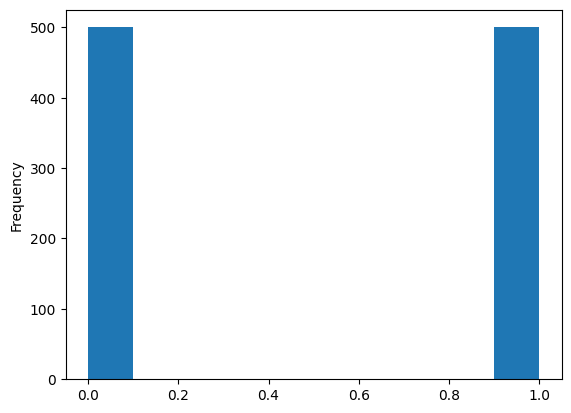

In [30]:
df.shape

df.label.plot(kind='hist')

In [ ]:
df.to_csv("/home/gdallagl/myworkdir/ESMSec/data/protein/cyto_sec_dataset.csv", index=False)

In [40]:
import requests
import pandas as pd
from io import StringIO
import random
import time

def _normalize_uniprot_tsv_df(df):
    """Normalize UniProt TSV column names to standard format."""
    accession_col = None
    sequence_col = None
    
    for name in df.columns:
        nl = name.lower()
        if accession_col is None and nl in ("entry", "accession", "primary accession", "entry name"):
            accession_col = name
        if sequence_col is None and "sequence" in nl:
            sequence_col = name
    
    if accession_col is None or sequence_col is None:
        raise KeyError(f"Missing required columns. Available: {list(df.columns)}")
    
    return pd.DataFrame({
        'protein': df[accession_col].astype(str),
        'sequence': df[sequence_col].astype(str)
    })

def fetch_proteins_with_pagination(keyword, n, organism="Homo sapiens", exclude=set()):
    """
    Fetch n unique proteins using pagination (multiple 500-result batches).
    Excludes proteins in the 'exclude' set.
    """
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    query = f'keyword:"{keyword}" AND organism_name:"{organism}"'
    
    collected = []
    collected_ids = set()
    offset = 0
    batch_size = 500  # UniProt's max per request
    
    print(f"  Fetching proteins for keyword {keyword} (target: {n})...")
    
    while len(collected) < n:
        params = {
            "query": query,
            "format": "tsv",
            "fields": "accession,sequence",
            "size": batch_size,
            "offset": offset
        }
        
        try:
            resp = requests.get(base_url, params=params, timeout=30)
            
            if resp.status_code != 200:
                print(f"    Warning: Request failed with status {resp.status_code}")
                break
            
            df_batch = pd.read_csv(StringIO(resp.text), sep="\t", dtype=str)
            
            if df_batch.empty:
                print(f"    No more results at offset {offset}")
                break
            
            df_batch = _normalize_uniprot_tsv_df(df_batch)
            
            # Filter and collect unique proteins
            added_this_batch = 0
            for _, row in df_batch.iterrows():
                pid = row['protein']
                
                # Skip if already collected, excluded, or duplicate
                if pid in collected_ids or pid in exclude:
                    continue
                
                collected.append({'protein': pid, 'sequence': row['sequence']})
                collected_ids.add(pid)
                added_this_batch += 1
                
                if len(collected) >= n:
                    break
            
            print(f"    Offset {offset}: got {len(df_batch)} results, added {added_this_batch} unique (total: {len(collected)}/{n})")
            
            # If we got fewer results than batch_size, we've reached the end
            if len(df_batch) < batch_size:
                print(f"    Reached end of available results")
                break
            
            # If we added nothing new from a full batch, likely no more unique results
            if added_this_batch == 0 and len(df_batch) == batch_size:
                print(f"    No new unique proteins found, stopping")
                break
            
            offset += batch_size
            time.sleep(0.2)  # Be nice to the API
            
        except Exception as e:
            print(f"    Error at offset {offset}: {e}")
            break
    
    return pd.DataFrame(collected)

def create_protein_df_disjoint(secreted_n=1000, cytoplasm_n=1000, organism="Homo sapiens"):
    """
    Create a dataset with disjoint sets of secreted and cytoplasmic proteins.
    Uses pagination to fetch large numbers of proteins.
    """
    print(f"\n{'='*60}")
    print(f"Fetching {secreted_n} secreted + {cytoplasm_n} cytoplasmic proteins")
    print(f"{'='*60}\n")
    
    # 1) Fetch secreted proteins
    print(f"Step 1: Fetching secreted proteins (KW-0964)...")
    df_secreted = fetch_proteins_with_pagination("KW-0964", secreted_n, organism=organism)
    print(f"  ✓ Got {len(df_secreted)} secreted proteins.\n")
    
    # 2) Fetch cytoplasmic proteins, excluding secreted ones
    secreted_ids = set(df_secreted['protein'].tolist())
    print(f"Step 2: Fetching cytoplasmic proteins (KW-0378), excluding {len(secreted_ids)} secreted IDs...")
    df_cyt = fetch_proteins_with_pagination("KW-0378", cytoplasm_n, organism=organism, exclude=secreted_ids)
    print(f"  ✓ Got {len(df_cyt)} cytoplasmic proteins.\n")
    
    # Warn if we couldn't reach targets
    if len(df_secreted) < secreted_n:
        print(f"⚠ Warning: Only found {len(df_secreted)}/{secreted_n} unique secreted proteins.")
    if len(df_cyt) < cytoplasm_n:
        print(f"⚠ Warning: Only found {len(df_cyt)}/{cytoplasm_n} unique cytoplasmic proteins.")
    
    # Label classes
    df_secreted['label'] = 1  # secreted
    df_cyt['label'] = 0       # cytoplasmic
    
    # Combine
    df = pd.concat([
        df_secreted[['protein', 'sequence', 'label']],
        df_cyt[['protein', 'sequence', 'label']]
    ], ignore_index=True)
    
    # Assign train/validation/test splits (70/15/15)
    def assign_set(label):
        r = random.random()
        if r < 0.7:
            return 'train'
        elif r < 0.85:
            return 'validation'
        else:
            return 'test'
    
    df['set'] = df['label'].apply(lambda x: assign_set(x))
    
    return df

if __name__ == "__main__":
    random.seed(42)  # For reproducibility
    
    # Fetch dataset with 2000 proteins per class
    df = create_protein_df_disjoint(secreted_n=2000, cytoplasm_n=2000)
    
    print("\n" + "="*60)
    print("FINAL DATASET")
    print("="*60)
    print(f"Total rows: {len(df)}")
    print(f"\nClass distribution:")
    print(df['label'].value_counts().sort_index())
    print(f"\nSet distribution:")
    print(df['set'].value_counts())
    print(f"\nSample rows:")
    display(df.head(3))
    
    # Optionally save to CSV
    # df.to_csv('protein_dataset.csv', index=False)
    # print("\nDataset saved to 'protein_dataset.csv'")


Fetching 2000 secreted + 2000 cytoplasmic proteins

Step 1: Fetching secreted proteins (KW-0964)...
  Fetching proteins for keyword KW-0964 (target: 2000)...
    Offset 0: got 500 results, added 500 unique (total: 500/2000)
    Offset 500: got 500 results, added 0 unique (total: 500/2000)
    No new unique proteins found, stopping
  ✓ Got 500 secreted proteins.

Step 2: Fetching cytoplasmic proteins (KW-0378), excluding 500 secreted IDs...
  Fetching proteins for keyword KW-0378 (target: 2000)...
    Offset 0: got 500 results, added 416 unique (total: 416/2000)
    Offset 500: got 500 results, added 0 unique (total: 416/2000)
    No new unique proteins found, stopping
  ✓ Got 416 cytoplasmic proteins.

⚠ Warning: Only found 500/2000 unique secreted proteins.
⚠ Warning: Only found 416/2000 unique cytoplasmic proteins.

FINAL DATASET
Total rows: 916

Class distribution:
label
0    416
1    500
Name: count, dtype: int64

Set distribution:
set
train         641
test          145
validatio

,protein,sequence,label,set
0,A0A0C5B5G6,MRWQEMGYIFYPRKLR,1,train
1,B2RUY7,MALHIHEACILLLVIPGLVTSAAISHEDYPADEGDQISSNDNLIFD...,1,train
2,O00300,MNNLLCCALVFLDISIKWTTQETFPPKYLHYDEETSHQLLCDKCPP...,1,train


In [41]:
df.to_csv("/home/gdallagl/myworkdir/ESMSec/data/protein/cyto_sec_dataset_claude.csv", index=False)

# Big Dataset


In [25]:
import requests
import pandas as pd
import time
import re
import os
import random # Added for random dataset splitting

# --- Configuration ---
UNIPROT_SEARCH_URL = "https://rest.uniprot.org/uniprotkb/search"
# Target number of proteins for each class (N and M must be > 1000)
TARGET_COUNT = 10000 
PAGE_SIZE = 500 # Max results per page for UniProt API is often 500 or 1000
OUTPUT_FILENAME = "protein_secretion_dataset.tsv"

# --- Queries for Secreted and Non-Secreted Proteins ---
# Secreted proteins (N): Uses the standard UniProt keyword for secreted proteins
SECRETED_QUERY = 'keyword:"Secreted"'
# Non-Secreted proteins (M): Focuses on Nuclear proteins using the specific 
# subcellular location field and explicitly excludes any entries also tagged 
# as "Secreted" to ensure class purity.
NON_SECRETED_QUERY = '(cc_subcellular_location:"Nucleus" OR cc_subcellular_location:"Cytoplasm" OR cc_subcellular_location:"Mitochondrion" OR cc_subcellular_location:"Cytoskeleton" OR cc_subcellular_location:"Peroxisome" OR cc_subcellular_location:"Cell membrane") AND NOT keyword:"Secreted"'

def fetch_proteins(query, label, target_count):
    """
    Fetches protein data from UniProt, handling pagination until the target count 
    is reached or no more results are available.
    
    Args:
        query (str): The UniProt query string.
        label (int): The classification label (1 for Secreted, 0 for Non-Secreted).
        target_count (int): The minimum number of entries to fetch.
        
    Returns:
        list: A list of dictionaries containing protein (Accession), sequence, and label.
    """
    label_name = "Secreted" if label == 1 else "Non-Secreted"
    print(f"--- Fetching {target_count} '{label_name}' proteins (Query: {query}) ---")
    
    all_data = []
    cursor = None
    count = 0
    
    # Define the fields to retrieve (Accession and Sequence are essential)
    fields = "accession,sequence"
    
    while count < target_count:
        params = {
            "query": query,
            "format": "json",
            "size": PAGE_SIZE,
            "fields": fields,
        }
        
        if cursor:
            params["cursor"] = cursor
            
        try:
            # Implement simple exponential backoff for rate limiting
            for attempt in range(4):
                response = requests.get(UNIPROT_SEARCH_URL, params=params)
                if response.status_code == 200:
                    break
                elif response.status_code == 429: # Too Many Requests
                    delay = 2 ** attempt
                    print(f"Rate limit hit. Retrying in {delay} seconds...")
                    time.sleep(delay)
                else:
                    response.raise_for_status()
            else:
                print(f"Failed to fetch data after multiple retries. Status: {response.status_code}")
                return all_data

            data = response.json()
            results = data.get("results", [])
            
            if not results:
                print(f"No more results found for query: {query}")
                break
                
            # Process results
            for entry in results:
                if count >= target_count:
                    break
                    
                accession = entry.get("primaryAccession")
                # Sequence is nested under a 'sequence' object in the JSON response
                sequence = entry.get("sequence", {}).get("value")
                
                # Only use entries with complete sequence data
                if accession and sequence:
                    # Store data with required column names (protein, sequence, label)
                    all_data.append({
                        "protein": accession,
                        "sequence": sequence,
                        "label": label # Stores 1 or 0
                    })
                    count += 1
            
            print(f"Fetched {len(results)} entries. Total collected: {count}")
            
            # --- Pagination: Extract the cursor for the next page ---
            link_header = response.headers.get("Link")
            next_cursor_match = None
            
            if link_header:
                # Look for the URL segment that contains 'cursor=' and is marked rel="next"
                parts = link_header.split(',')
                for part in parts:
                    if 'rel="next"' in part:
                        # Extract the cursor value from the link URL using regex
                        match = re.search(r'cursor=([a-zA-Z0-9]+)', part)
                        if match:
                            next_cursor_match = match.group(1)
                            break
            
            if next_cursor_match:
                cursor = next_cursor_match
            else:
                # No 'next' link found, we reached the end of results
                print("Reached end of search results (No next cursor).")
                break
                
            # Wait a short period to be polite to the API
            time.sleep(0.5)

        except requests.exceptions.RequestException as e:
            print(f"An error occurred during API request: {e}")
            break
            
    print(f"Finished fetching. Final count for '{label_name}': {count}\n")
    return all_data


# Check for required libraries before starting
try:
    import requests
    import pandas as pd
    import re
    import random
except ImportError as e:
    # Check if the missing module is one of the core dependencies
    if 'requests' in str(e) or 'pandas' in str(e):
            print("Error: This script requires 'requests' and 'pandas'.")
            print("Please install them using: pip install requests pandas")
    else:
            print(f"An unexpected import error occurred: {e}")


"""
Main function to orchestrate data fetching and saving.
"""
# 1. Fetch Data (1 for Secreted, 0 for Non-Secreted)
secreted_proteins = fetch_proteins(SECRETED_QUERY, 1, TARGET_COUNT)
non_secreted_proteins = fetch_proteins(NON_SECRETED_QUERY, 0, TARGET_COUNT)

# 2. Combine Data and Create DataFrame
all_proteins = secreted_proteins + non_secreted_proteins

N = len(secreted_proteins)
M = len(non_secreted_proteins)

print("--- Summary ---")
print(f"Target count: >1000")
print(f"Final Secreted count (N): {N}")
print(f"Final Non-Secreted count (M): {M}")

if N < TARGET_COUNT or M < TARGET_COUNT:
    print("\nWARNING: One or both classes failed to reach the >1000 target.")
    print("This means UniProt did not return enough unique entries matching the specific query criteria.")
    
if not all_proteins:
    print("No data was collected. Exiting.")

df = pd.DataFrame(all_proteins)

# 3. Add the 'set' column for train/val/test split
# Using 80% train, 10% val, 10% test split ratio
sets = ['train', 'val', 'test']
weights = [0.8, 0.1, 0.1]

# Randomly assign a set label to each row based on weights
df['set'] = random.choices(sets, weights, k=len(df))

# 4. Save and Print Output
df.to_csv(OUTPUT_FILENAME, sep='\t', index=False)

print(f"\nDataset successfully saved to '{OUTPUT_FILENAME}'")

# Display the first few rows for confirmation
print("\n--- First 5 rows of the generated dataset ---")
# Using .to_string() for clean output without requiring 'tabulate'
print(df.head().to_string(index=False))




--- Fetching 10000 'Secreted' proteins (Query: keyword:"Secreted") ---
Fetched 500 entries. Total collected: 500
Fetched 500 entries. Total collected: 1000
Fetched 500 entries. Total collected: 1500
Fetched 500 entries. Total collected: 2000
Fetched 500 entries. Total collected: 2500
Fetched 500 entries. Total collected: 3000
Fetched 500 entries. Total collected: 3500
Fetched 500 entries. Total collected: 4000
Fetched 500 entries. Total collected: 4500
Fetched 500 entries. Total collected: 5000
Fetched 500 entries. Total collected: 5500
Fetched 500 entries. Total collected: 6000
Fetched 500 entries. Total collected: 6500
Fetched 500 entries. Total collected: 7000
Fetched 500 entries. Total collected: 7500
Fetched 500 entries. Total collected: 8000
Fetched 500 entries. Total collected: 8500
Fetched 500 entries. Total collected: 9000
Fetched 500 entries. Total collected: 9500
Fetched 500 entries. Total collected: 10000
Finished fetching. Final count for 'Secreted': 10000

--- Fetching 10

In [27]:
display(df.head(9))

print(df.label.value_counts())

df.protein.nunique(), df.shape

,protein,sequence,label,set
0,A0A0C5B5G6,MRWQEMGYIFYPRKLR,1,train
1,B2RUY7,MALHIHEACILLLVIPGLVTSAAISHEDYPADEGDQISSNDNLIFD...,1,train
2,O00300,MNNLLCCALVFLDISIKWTTQETFPPKYLHYDEETSHQLLCDKCPP...,1,train
3,O00560,MSLYPSLEDLKVDKVIQAQTAFSANPANPAILSEASAPIPHDGNLY...,1,train
4,O00622,MSSRIARALALVVTLLHLTRLALSTCPAACHCPLEAPKCAPGVGLV...,1,train
5,O14638,MESTLTLATEQPVKKNTLKKYKIACIVLLALLVIMSLGLGLGLGLR...,1,val
6,O14788,MRRASRDYTKYLRGSEEMGGGPGAPHEGPLHAPPPPAPHQPPAASR...,1,train
7,O14960,MFSTKALLLAGLISTALAGPWANICAGKSSNEIRTCDRHGCGQYSA...,1,train
8,O15230,MAKRLCAGSALCVRGPRGPAPLLLVGLALLGAARAREEAGGGFSLH...,1,train


label
1    10000
0    10000
Name: count, dtype: int64


(20000, (20000, 4))

In [28]:
df.to_csv("/home/gdallagl/myworkdir/ESMSec/data/protein/sec_vs_all_uniprot.csv", index=False)